In [2]:
from quantrocket.license import set_license

In [9]:
set_license("04e78c58-dfa8-11ee-ad12-51b9131ec94a")

{'licensekey': '04e7........c94a', 'software_license': {}}

In [ ]:
from quantrocket.history import create_usstock_db
create_usstock_db("usstock-free-1d", bar_size="1 day", free=True)

In [7]:
from quantrocket.history import collect_history
collect_history("usstock-free-1d")

{'status': 'the historical data will be collected asynchronously'}

In [7]:
from quantrocket.master import get_securities
# by specifying sec_types='STK', we exclude ETFs, which are present in the sample data 
securities = get_securities(vendors="usstock", sec_types="STK")
securities.head()

,Symbol,Exchange,Country,Currency,SecType,Etf,Timezone,Name,PriceMagnifier,Multiplier,Delisted,DateDelisted,LastTradeDate,RolloverDate
Sid,,,,,,,,,,,,,,
FIBBG000B9XRY4,AAPL,XNAS,US,USD,STK,False,America/New_York,APPLE INC,1,1,False,NaT,NaT,NaT
FIBBG000BFWKC0,MON,XNYS,US,USD,STK,False,America/New_York,MONSANTO CO,1,1,True,2018-06-06,NaT,NaT
FIBBG000BKZB36,HD,XNYS,US,USD,STK,False,America/New_York,HOME DEPOT INC,1,1,False,NaT,NaT,NaT
FIBBG000BMHYD1,JNJ,XNYS,US,USD,STK,False,America/New_York,JOHNSON & JOHNSON,1,1,False,NaT,NaT,NaT
FIBBG000BPH459,MSFT,XNAS,US,USD,STK,False,America/New_York,MICROSOFT CORP,1,1,False,NaT,NaT,NaT


In [8]:
from quantrocket.master import create_universe
create_universe("usstock-free", sids=securities.index.tolist())

HTTPError: ('400 Client Error: BAD REQUEST for url: http://houston/master/universes/usstock-free?sids=FIBBG000B9XRY4&sids=FIBBG000BFWKC0&sids=FIBBG000BKZB36&sids=FIBBG000BMHYD1&sids=FIBBG000BPH459&sids=FIBBG000CK38G3&sids=FIBBG000GZQ728&sids=FIBBG00B3T3HD3', {'status': 'error', 'msg': "universe 'usstock-free' already exists, please indicate whether to replace it or append to it"})

In [2]:
filtered_securities = securities[securities.Symbol=="AAPL"]
filtered_securities = filtered_securities[["Symbol", "Exchange", "Name", "Delisted"]]
filtered_securities.head()

NameError: name 'securities' is not defined

In [29]:
create_universe("usstock-free-active1", sids=filtered_securities.index.tolist())

{'code': 'usstock-free-active1',
 'provided': 1,
 'inserted': 1,
 'total_after_insert': 1}

# **Price data of Apple stock for the year 2023**

In [9]:
from quantrocket import get_prices
prices = get_prices("usstock-free-1d", universes="usstock-free-active1", start_date="2023-01-01", end_date="2023-12-31", fields=["Close"])
prices.head(100)

Sid               FIBBG000B9XRY4
Field Date                      
Close 2023-01-03        124.2163
      2023-01-04        125.4975
      2023-01-05        124.1666
      2023-01-06        128.7352
      2023-01-09        129.2616
...                          ...
      2023-05-19        174.4710
      2023-05-22        173.5148
      2023-05-23        170.8852
      2023-05-24        171.1641
      2023-05-25        172.3095

[100 rows x 1 columns]

In [11]:
prices.to_csv("appleStock.csv")
import pandas as pd

In [12]:
df = pd.read_csv("appleStock.csv",parse_dates=True)
df.set_index('Date', inplace=True)
df = df.drop(["Field"],axis="columns")

In [13]:
df.rename(columns={'FIBBG000B9XRY4': 'close_price'}, inplace=True)

print(df)

            close_price
Date                   
2023-01-03     124.2163
2023-01-04     125.4975
2023-01-05     124.1666
2023-01-06     128.7352
2023-01-09     129.2616
...                 ...
2023-12-22     193.3533
2023-12-26     192.8040
2023-12-27     192.9038
2023-12-28     193.3333
2023-12-29     192.2846

[250 rows x 1 columns]


# **Calculating Returns and Classifying the States**

In [14]:
df['Returns'] = df['close_price'].pct_change()

In [15]:
def classify_state(return_val):
    if return_val >= 0.01:
        return 1  
    elif return_val > -0.01:
        return 0  
    else:
        return -1

df['State'] = df['Returns'].apply(classify_state)


In [16]:
def return_classify(state):
    if state==1:
        return "Bull"
    elif state==0:
        return "Flat"
    else:
        return "Bear"
    
df['State_name'] = df['State'].apply(return_classify)


,close_price,Returns,State,State_name
Date,,,,
2023-01-03,124.2163,NaN,-1,Bear
2023-01-04,125.4975,0.010314,1,Bull
2023-01-05,124.1666,-0.010605,-1,Bear
2023-01-06,128.7352,0.036794,1,Bull
2023-01-09,129.2616,0.004089,0,Flat
...,...,...,...,...
2023-12-22,193.3533,-0.005547,0,Flat
2023-12-26,192.8040,-0.002841,0,Flat
2023-12-27,192.9038,0.000518,0,Flat


# Calculating **"Portfolio"** Value using the given conditions

In [18]:
def classify_value(state1,state2,v):
    if state1 ==1 and state2 ==0:
        return v+1
    elif state1==-1 and state2==0:
        return v-1
    else:
        return v
    
df['Portfolio']=0
for i in range(1, len(df)):
    df.at[df.index[i], 'Portfolio'] = classify_value(df.at[df.index[i], 'State'], df.at[df.index[i-1], 'State'], df.at[df.index[i-1], 'Portfolio'])
print(df['Portfolio'].max())
print(df)

18
            close_price   Returns  State State_name  Portfolio
Date                                                          
2023-01-03     124.2163       NaN     -1       Bear          0
2023-01-04     125.4975  0.010314      1       Bull          0
2023-01-05     124.1666 -0.010605     -1       Bear          0
2023-01-06     128.7352  0.036794      1       Bull          0
2023-01-09     129.2616  0.004089      0       Flat          0
...                 ...       ...    ...        ...        ...
2023-12-22     193.3533 -0.005547      0       Flat         17
2023-12-26     192.8040 -0.002841      0       Flat         17
2023-12-27     192.9038  0.000518      0       Flat         17
2023-12-28     193.3333  0.002226      0       Flat         17
2023-12-29     192.2846 -0.005424      0       Flat         17

[250 rows x 5 columns]


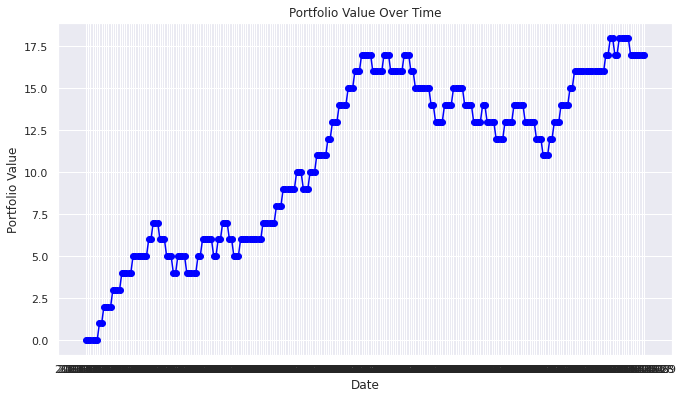

In [194]:
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 6))
plt.plot(df.index, df['Portfolio'], color='blue', marker='o')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()


In [19]:
import numpy as np

transition_matrix = np.zeros((3, 3))  # 3 states: Bull,Flat,Bear or -1,0,1
for i in range(1, len(df)):
    current_state = df.at[df.index[i], 'State']
    previous_state = df.at[df.index[i-1], 'State']

    transition_matrix[previous_state + 1, current_state + 1] += 1

transition_matrix = transition_matrix / np.sum(transition_matrix, axis=1, keepdims=True)
print(transition_matrix)

[[0.13888889 0.72222222 0.13888889]
 [0.14649682 0.59872611 0.25477707]
 [0.125      0.67857143 0.19642857]]


In [20]:
df.to_csv("appleStock1.csv")

print(df.tail(10))
print(df)

            close_price   Returns  State State_name  Portfolio
Date                                                          
2023-12-15     197.3182 -0.002726      0       Flat         18
2023-12-18     195.6404 -0.008503      0       Flat         18
2023-12-19     196.6890  0.005360      0       Flat         18
2023-12-20     194.5817 -0.010714     -1       Bear         17
2023-12-21     194.4319 -0.000770      0       Flat         17
2023-12-22     193.3533 -0.005547      0       Flat         17
2023-12-26     192.8040 -0.002841      0       Flat         17
2023-12-27     192.9038  0.000518      0       Flat         17
2023-12-28     193.3333  0.002226      0       Flat         17
2023-12-29     192.2846 -0.005424      0       Flat         17
            close_price   Returns  State State_name  Portfolio
Date                                                          
2023-01-03     124.2163       NaN     -1       Bear          0
2023-01-04     125.4975  0.010314      1       Bull    

# **Final Result**

In [178]:
#To maximize V(N)

buy_indices = []
 
# We will only buy when there is increment , to maximize the portfolio value V(N)...

for i in range(0, len(df)):
    current_state = df.at[df.index[i], 'State']
    previous_state = df.at[df.index[i-1], 'State']
    
    if current_state == 1 and previous_state == 0:
        buy_indices.append(i)
        

print("Optimal Buy Indices: ", buy_indices)
print()
print("Maximum Portfolio Value V(N) : ", len(buy_indices))


Optimal Buy Indices:  [6, 8, 12, 16, 21, 28, 30, 41, 50, 52, 59, 61, 69, 79, 85, 88, 94, 100, 103, 108, 110, 113, 117, 120, 123, 133, 142, 160, 164, 177, 187, 191, 207, 209, 212, 216, 218, 232, 234, 238]

Maximum Portfolio Value V(N) :  40


In [ ]:
#If we consider increment in state -1 to 1 change condition in the above if statement
#=>  if current_state == 1 and previous_state == 0 or current_state == 1 and previous_state == -1:  
#=> O/P:45

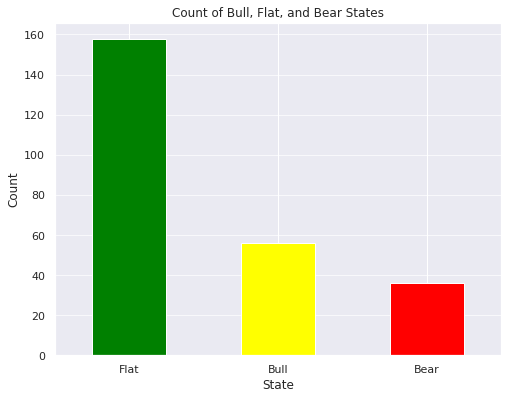

In [185]:
import matplotlib.pyplot as plt

state_counts = df['State_name'].value_counts()

plt.figure(figsize=(8, 6))
state_counts.plot(kind='bar', color=['green', 'yellow', 'red'])
plt.title('Count of Bull, Flat, and Bear States')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.7)
plt.show()
